In [1]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

In [14]:
# reading in existing dG dataset
dft_data = pd.read_csv('data/dft_robert_input.csv')
dG_data = dft_data[['Cofactor', 'dG_C5']]

In [15]:
# using assigned names
cofactor_name = dG_data['Cofactor'].to_list()
cofactor_name

names = []
for i in cofactor_name:
    name = i.split('_')[0]
    names.append(name)

dG_data = dG_data.drop(columns=['Cofactor'],axis=1)
dG_data['Cofactor'] = names

In [16]:
# isolating BMCs selected for TS calculations
bmcs_to_sample = ['A1a', 'A5a', 'A5b', 'A3b', 'B2b', 'B3a', 'B6b', 'D5b', 'D3a', 'D6a', 
                  'C1b', 'C3b', 'C6a', 'E1a', 'E1b', 'E2a', 'E2b', 'E3a', 'E3b', 'J1a', 
                  'J1b', 'J5a', 'J5b', 'J4a', 'F1a', 'F3b', 'F6a', 'G3b', 'G4a', 'K1b', 
                  'K3a', 'K3b', 'K4b', 'K6b']

selected_dG_data = dG_data.loc[dG_data['Cofactor'].isin(bmcs_to_sample)]

,dG_C5,Cofactor
0,-134.694337,A1a
4,-140.867475,A5a
5,-137.755389,A5b
7,-128.243271,A3b
15,-128.130480,B2b
18,-133.134481,B3a
23,-129.941696,B6b
29,-138.388458,D5b
30,-132.157043,D3a
34,-133.067929,D6a


In [18]:
# finding barrier data
kinetic_barrier = pd.read_csv('data/kinetic_barrier_large-subset.csv')
barriers = kinetic_barrier[['Cofactor Name','barrier']]
barriers['Cofactor'] = bmcs_to_sample
barriers = barriers.drop(columns=['Cofactor Name'],axis=1)

/var/folders/nh/3ms2hwln7kv2bfrhtl8myjr00000gn/T/ipykernel_81948/914418229.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  barriers['Cofactor'] = bmcs_to_sample


,barrier,Cofactor
0,22.225947,A1a
1,19.465050,A5a
2,21.619885,A5b
3,26.623102,A3b
4,25.779059,B2b
5,22.337833,B3a
6,24.774525,B6b
7,22.437428,D5b
8,26.096818,D3a
9,23.655337,D6a


In [20]:
# merging large datasets
large_set_corr_data = pd.merge(selected_dG_data,barriers,on='Cofactor')

,dG_C5,Cofactor,barrier
0,-134.694337,A1a,22.225947
1,-140.867475,A5a,19.465050
2,-137.755389,A5b,21.619885
3,-128.243271,A3b,26.623102
4,-128.130480,B2b,25.779059
5,-133.134481,B3a,22.337833
6,-129.941696,B6b,24.774525
7,-138.388458,D5b,22.437428
8,-132.157043,D3a,26.096818
9,-133.067929,D6a,23.655337


In [31]:
selected_r3H = []
selected_r3Me = []

for idx,row in large_set_corr_data.iterrows():
    cofactor_id = row['Cofactor']
    if 'a' in cofactor_id:
        selected_r3H.append(cofactor_id)
    elif 'b' in cofactor_id:
        selected_r3Me.append(cofactor_id)

r3H_correlation_data = large_set_corr_data.loc[large_set_corr_data['Cofactor'].isin(selected_r3H)]
r3Me_correlation_data = large_set_corr_data.loc[large_set_corr_data['Cofactor'].isin(selected_r3Me)]

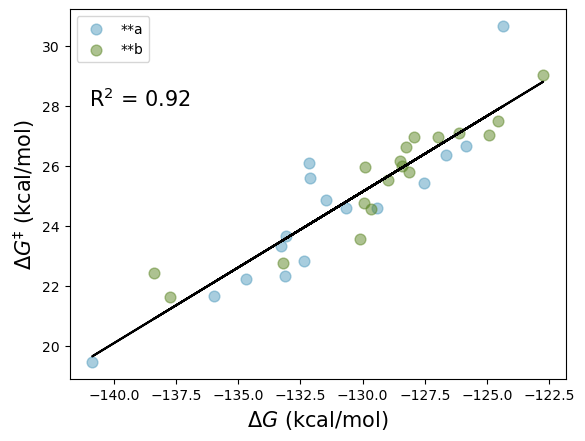

In [34]:
import scipy
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(large_set_corr_data['dG_C5'],
                                                                     large_set_corr_data['barrier'])
abline_values = [slope * i + intercept for i in large_set_corr_data['dG_C5']]

plt.plot(large_set_corr_data['dG_C5'],abline_values,color='#000000')
plt.scatter(r3H_correlation_data['dG_C5'],r3H_correlation_data['barrier'],
            color='#529cbe',s=60, label='**a',alpha=0.50,edgecolors='#529cbe')
plt.scatter(r3Me_correlation_data['dG_C5'],r3Me_correlation_data['barrier'],
            color='#5c8625',s=60, label='**b',alpha=0.50,edgecolors='#5c8625')
plt.ylabel(r'$\Delta ' + u'G^{{\u2021}}$ (kcal/mol)',fontsize=15)
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)
plt.annotate(f'R$^2$ = {"{:.2f}".format(r_value)}'.format(r2_score(large_set_corr_data['dG_C5'], 
                                                                   large_set_corr_data['barrier'])), 
                                                                   (-141, 28),fontsize=15)
plt.legend()

# plt.savefig('corr_plot_coloredr3.svg',dpi=400)

In [37]:
# adding novel structures
# finding barrier data
new_kinetic_barrier = pd.read_csv('data/kinetic_barrier_new-subs.csv')
new_barriers = new_kinetic_barrier[['Cofactor Name','barrier']]

new_dG_dict = {'Cofactor Name' : ['NsubI','NsubII','NsubIII','NsubIV','NsubV','NsubVI',
                             'NsubS','C3subI','C3subII','C3subIII','C3subIV',
                             'C5subI','C5subII'],
               'dG_C5' : [-122.0,-120.8,-121.3,-117.3,-122.4,-121.7,-117.2,
                          -124.8,-125.2,-127.5,-120.0,-122.0,-117.1]}
new_dGs = pd.DataFrame.from_dict(new_dG_dict)

new_corr = pd.merge(new_barriers,new_dGs,on='Cofactor Name')

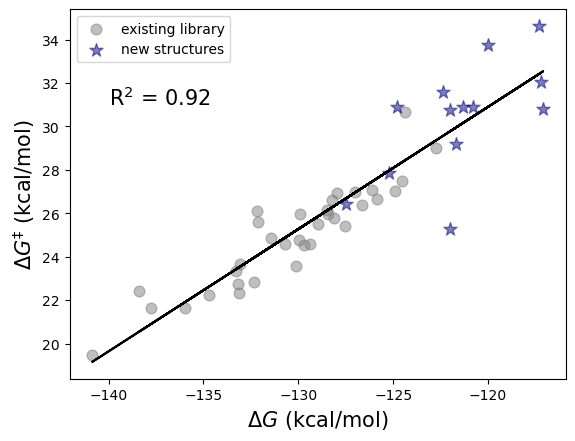

In [42]:
all_corr = pd.concat([large_set_corr_data,new_corr])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(all_corr['dG_C5'],
                                                                     all_corr['barrier'])
abline_values = [slope * i + intercept for i in all_corr['dG_C5']]

plt.plot(all_corr['dG_C5'],abline_values,color='#000000')
plt.scatter(large_set_corr_data['dG_C5'],large_set_corr_data['barrier'],
            color='#808080',s=60, label='existing library',alpha=0.50)
plt.scatter(new_corr['dG_C5'],new_corr['barrier'],
            color='#000080',s=100, label='new structures',alpha=0.50,marker='*')
plt.ylabel(r'$\Delta ' + u'G^{{\u2021}}$ (kcal/mol)',fontsize=15)
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)
plt.annotate(f'R$^2$ = {"{:.2f}".format(r_value)}'.format(r2_score(large_set_corr_data['dG_C5'], 
                                                                   large_set_corr_data['barrier'])), 
                                                                   (-140, 31),fontsize=15)
plt.legend()

# plt.savefig('corr_plot_new_structures.svg',dpi=400)

Text(0.5, 0, '$\\Delta G$ (kcal/mol)')

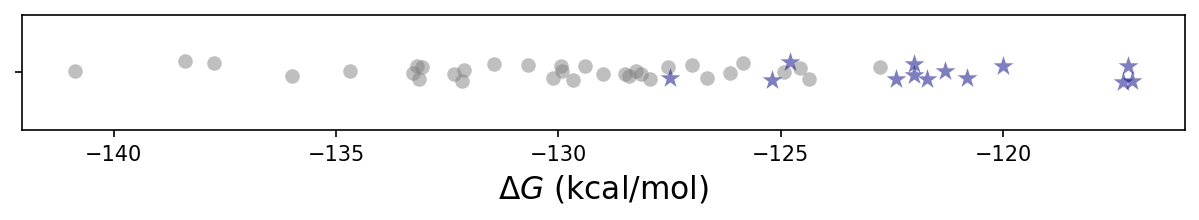

In [45]:
# showing distribution of stabilities for the full library including our new designed structures
import seaborn as sns 

# strip plot colored by current library or new
f = plt.figure(figsize=(10,1),dpi=150)
sns.stripplot(x=large_set_corr_data['dG_C5'], color='#808080', size=7, alpha=0.5, 
              edgecolors='#808080',marker='o')
sns.stripplot(x=new_corr['dG_C5'], color='#000080',size=10, alpha=0.5,
              edgecolors='#000080', marker='*')
plt.xlabel(r'$\Delta G$ (kcal/mol)',fontsize=15)

# plt.savefig('dG_comparison_library_vs_new.svg',dpi=400)